In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from megabouts.tracking_data.dataset import Dataset_TailTracking,Dataset_CentroidTracking,Dataset_FullTracking
from megabouts.pipeline.cfg import ConfigTrajPreprocess,ConfigTrajSegmentation,ConfigClassification
from megabouts.pipeline.centroid_tracking import  PipelineCentroidTracking

from megabouts.utils.utils_plot import display_trajectory
from megabouts.utils.utils import compute_outer_circle
from megabouts.utils import smallestenclosingcircle as smallestenclosingcircle
from megabouts.utils.utils_downsampling import convert_frame_duration,create_downsampling_function

from megabouts.utils.utils_bouts import NameCat

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors


from megabouts.utils.utils_bouts import compute_bout_cat_ts
from megabouts.utils.utils_benchmark import compute_bout_cat_matlab
from scipy import stats


## Load Dataset:

In [3]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')

x = df['x_blob'].values
y = df['y_blob'].values
body_angle = df['body_angle'].values
body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
body_angle = np.unwrap(body_angle)
# Center trajectory:
circle = compute_outer_circle(x,y)
x,y = x-circle[0],y-circle[1]

NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)


# Load Gold standard 

In [4]:
import pickle

filename = 'G://Megabouts_dataset//Full_Tracking_Pipeline//CatchAllBouts_atlas_20200525_1551.pickle'
with open(filename, 'rb') as handle:
            pipeline_results = pickle.load(handle)

# Extract Python Results
pipeline_results_full_tracking = pipeline_results['pipeline']

bout_cat_full = pipeline_results_full_tracking['bout_cat']
onset_full = pipeline_results_full_tracking['onset']
offset_full = pipeline_results_full_tracking['offset']

onset_full,offset_full = np.array(onset_full),np.array(offset_full)

bout_cat_ts_full,bout_cat_ts_signed_full = compute_bout_cat_ts(onset_full,offset_full,bout_cat_full,pipeline_results_full_tracking['x'].shape[0])


In [5]:
bout_cat_ts_matlab = pipeline_results['matlab']['bout_cat_ts']

### Subsample

In [6]:
tracking_tail_data = Dataset_TailTracking(fps=700,tail_angle=tail_angle)

# Downsample:
fps_new = 90
downsampling_f, Duration_after_Downsampling,original_t, new_t = create_downsampling_function(fps_new=fps_new,fps_origin=700,duration=len(x),duration_unit='frames',kind='linear')
#x_sub = downsampling_f(x,axis = 0)
#y_sub = downsampling_f(y,axis = 0)
#body_angle_sub = downsampling_f(body_angle,axis = 0)
tail_angle_sub = downsampling_f(tail_angle,axis = 0)

x_sub,y_sub,body_angle_sub  = map(lambda x : downsampling_f(x,axis=0),[x,y,body_angle])

### Check Data

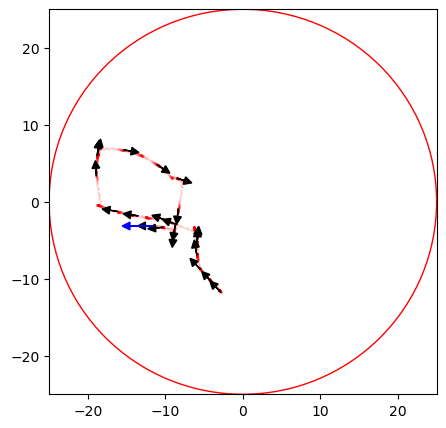

In [7]:
df_plot=pd.DataFrame(np.vstack((x_sub,y_sub,body_angle_sub)).T, 
columns=['x','y','angle'])
id = np.random.randint(df_plot.shape[0])
fig = display_trajectory(df_plot,index = id,past_memory=3*700)

# Parameters Tuning

### One euro filter

<font size="2">

The two parameters (fcmin and beta) can be set using a simple two-step procedure:
* First beta is set to 0 and fcmin (mincutoff) to a reasonable middle-ground value such as 1 Hz. Then the body part is held steady or moved at a very low speed while fcmin is adjusted to remove jitter and preserve an acceptable lag during these slow movements (decreasing fcmin reduces jitter but increases lag, fcmin must be > 0). 
* Next, the body part is moved quickly in different directions while beta is increased with a focus on minimizing lag. First find the right order of magnitude to tune beta, which depends on the kind of data you manipulate and their units: do not hesitate to start with values like 0.001 or 0.0001. You can first multiply and divide beta by factor 10 until you notice an effect on latency when moving quickly. 

Note that parameters fcmin and beta have clear conceptual relationships: if high speed lag is a problem, increase beta; if slow speed jitter is a problem, decrease fcmin.

</font>

In [8]:
from megabouts.preprocessing.smoothing import one_euro_filter


In [9]:
# Find smooth epoch:
Duration = fps_new*5
is_fish_stationnary = False 
while not is_fish_stationnary:
    
    IdSt = np.random.randint(x_sub.shape[0]-Duration)
    
    x_,y_,angle_ = x_sub[IdSt:IdSt+Duration],y_sub[IdSt:IdSt+Duration],body_angle_sub[IdSt:IdSt+Duration]
    
    extent = np.max(angle_)-np.min(angle_)
    if extent<0.05:
        is_fish_stationnary=True


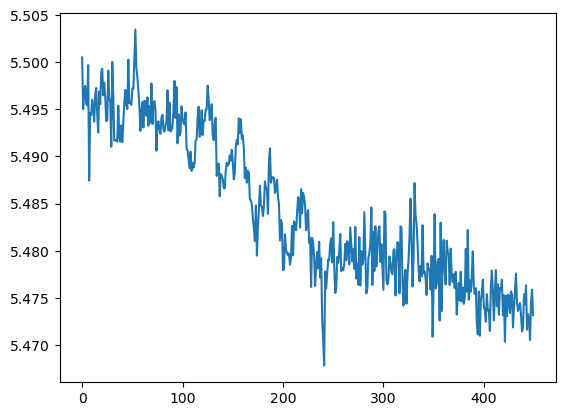

In [10]:

#plt.plot(x_sub[IdSt:IdSt+Duration])
#plt.plot(y_sub[IdSt:IdSt+Duration])
plt.plot(body_angle_sub[IdSt:IdSt+Duration])

(5.400510711652009, 5.600510711652008)

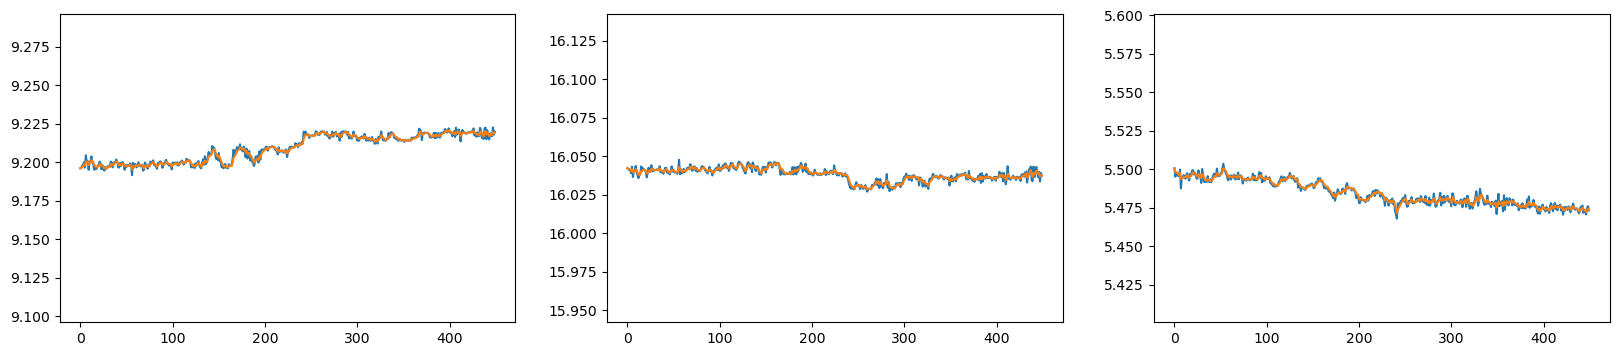

In [11]:
fc_min,beta = 10,0

smooth_func = lambda x : one_euro_filter(x,fc_min,beta,fps_new)
x_clean,y_clean,body_angle_clean  = map(smooth_func,[x_,y_,angle_])

IdSt,Duration = 0,len(x_)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(20,4))
Margin_Plot=0.1
ax1.plot(x_[IdSt:IdSt+Duration])
ax1.plot(x_clean[IdSt:IdSt+Duration])
ax1.set_ylim(x_[0]-Margin_Plot,x_[0]+Margin_Plot)
ax2.plot(y_[IdSt:IdSt+Duration])
ax2.plot(y_clean[IdSt:IdSt+Duration])
ax2.set_ylim(y_[0]-Margin_Plot,y_[0]+Margin_Plot)
ax3.plot(angle_[IdSt:IdSt+Duration])
ax3.plot(body_angle_clean[IdSt:IdSt+Duration])
ax3.set_ylim(angle_[0]-Margin_Plot,angle_[0]+Margin_Plot)


In [12]:
# Find fast movement epoch:
Duration = int(np.round(fps_new*0.2))
is_fish_stationnary = False 
while not is_fish_stationnary:
    
    IdSt = np.random.randint(x_sub.shape[0]-Duration)
    
    x_,y_,angle_ = x_sub[IdSt:IdSt+Duration],y_sub[IdSt:IdSt+Duration],body_angle_sub[IdSt:IdSt+Duration]
    
    extent = np.max(angle_)-np.min(angle_)
    if extent>3:
        is_fish_stationnary=True

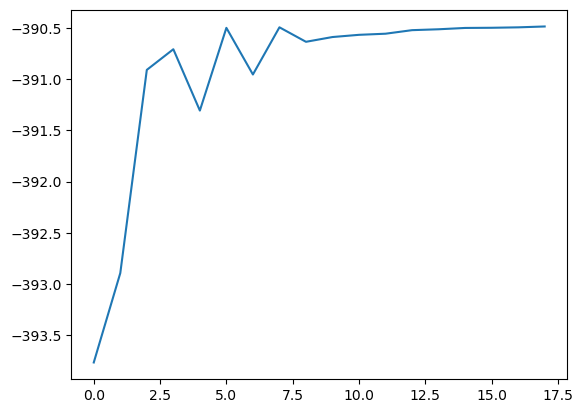

In [13]:
#plt.plot(x_sub[IdSt:IdSt+Duration])
#plt.plot(y_sub[IdSt:IdSt+Duration])
plt.plot(body_angle_sub[IdSt:IdSt+Duration])

(-396.7673303960335, -390.7673303960335)

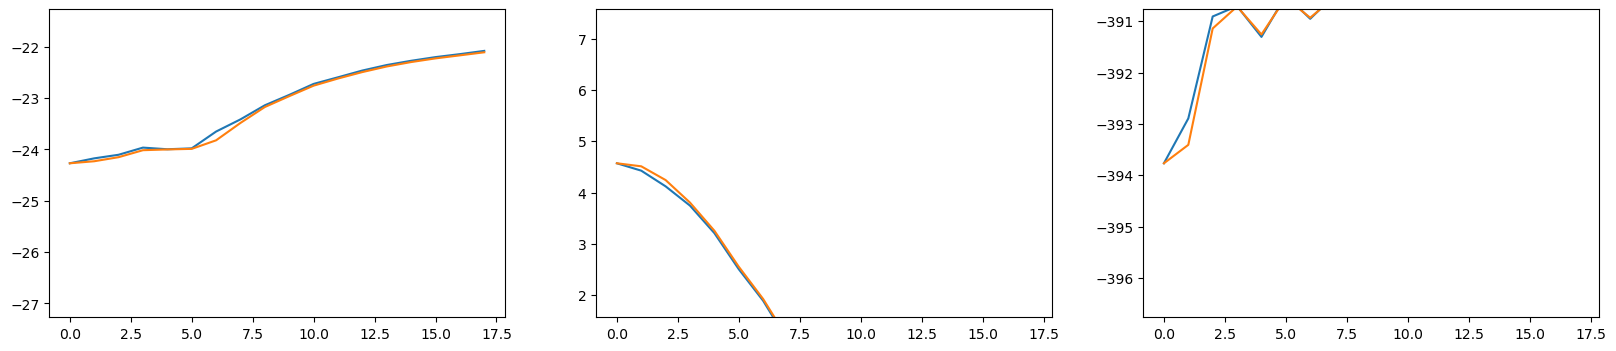

In [14]:
fc_min,beta = 10,4

smooth_func = lambda x : one_euro_filter(x,fc_min,beta,fps_new)
x_clean,y_clean,body_angle_clean  = map(smooth_func,[x_,y_,angle_])

IdSt,Duration = 0,len(x_)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(20,4))
Margin_Plot=3
ax1.plot(x_[IdSt:IdSt+Duration])
ax1.plot(x_clean[IdSt:IdSt+Duration])
ax1.set_ylim(x_[0]-Margin_Plot,x_[0]+Margin_Plot)
ax2.plot(y_[IdSt:IdSt+Duration])
ax2.plot(y_clean[IdSt:IdSt+Duration])
ax2.set_ylim(y_[0]-Margin_Plot,y_[0]+Margin_Plot)
ax3.plot(angle_[IdSt:IdSt+Duration])
ax3.plot(body_angle_clean[IdSt:IdSt+Duration])
ax3.set_ylim(angle_[0]-Margin_Plot,angle_[0]+Margin_Plot)


## Peak Finding

In [15]:
from scipy.signal import find_peaks

In [16]:
cfg_preprocess = ConfigTrajPreprocess(fps=fps_new,freq_cutoff_min=10,beta=4)
cfg_segment = ConfigTrajSegmentation(fps=fps_new)
cfg_classify = ConfigClassification(fps=fps_new)

pipeline = PipelineCentroidTracking(cfg_preprocess,cfg_segment,cfg_classify,load_training=False)

In [17]:
tracking_data = Dataset_CentroidTracking(fps=cfg_preprocess.fps,
                                         x=x_sub,
                                         y=y_sub,body_angle=body_angle_sub)

clean_traj = pipeline.preprocess(x=tracking_data.x,
                                 y=tracking_data.y,
                                 body_angle=tracking_data.body_angle)      

In [18]:

kinematic_activity = clean_traj.kinematic_activity

In [19]:
bout_duration = cfg_segment.bout_duration
# Number of peak as function of prominence:
prom_para = np.linspace(0.01,0.4,100)
num_peaks = np.zeros_like(prom_para)
for i,pro in enumerate(prom_para):
    peaks, _ = find_peaks(kinematic_activity,distance=bout_duration,prominence=pro)
    num_peaks[i] = len(peaks)


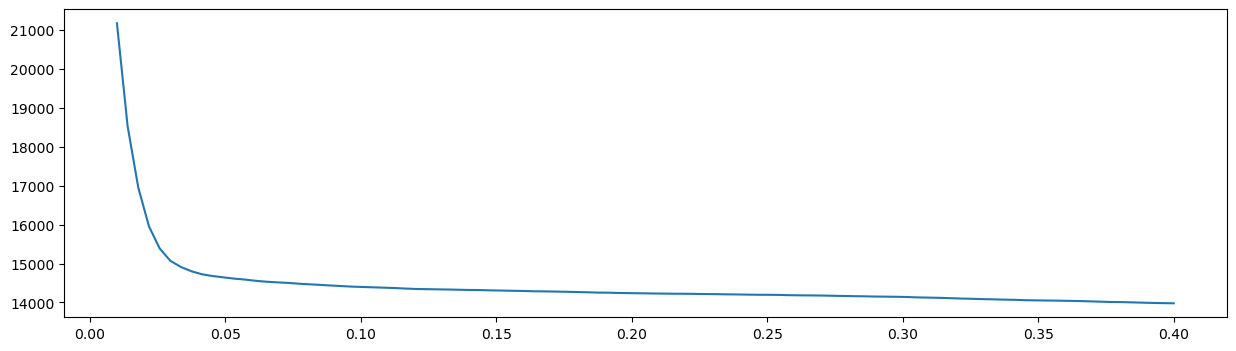

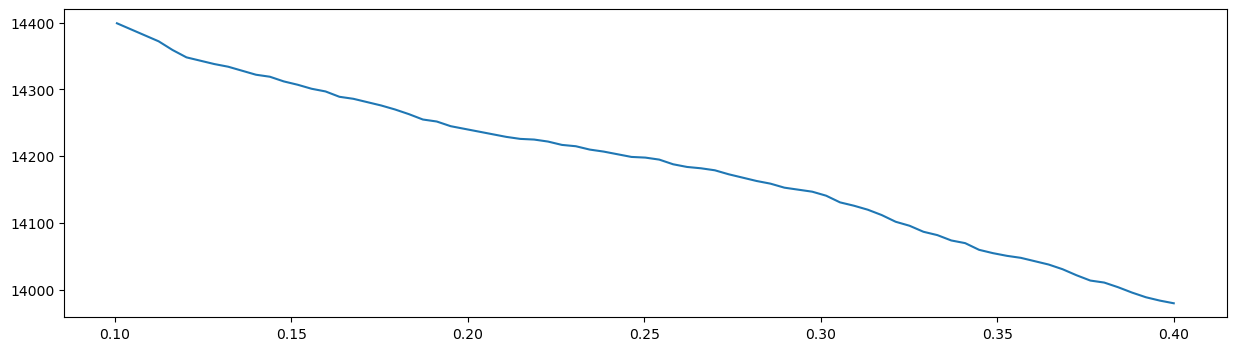

In [20]:
plt.figure(figsize=(15,4))
plt.plot(prom_para,num_peaks)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(prom_para[(prom_para>0.1)&(prom_para<2)],num_peaks[(prom_para>0.1)&(prom_para<2)])
plt.show()

In [21]:
fps_list = np.linspace(30,700,30)
fps_list = 10*np.round(fps_list/10).astype('int')

peak_prominence_list = np.linspace(0.1,1,30)

In [49]:
i = 16
fps_list[i],peak_prominence_list[i]

(400, 0.596551724137931)

# Run Pipeline

In [23]:
cfg_preprocess = ConfigTrajPreprocess(fps=fps_new,freq_cutoff_min=10,beta=4)

cfg_segment = ConfigTrajSegmentation(fps=fps_new,peak_prominence=.19,margin_before_peak_ms=34,bout_duration_ms=200)

cfg_classify = ConfigClassification(fps=fps_new,
                                    margin_before_peak_ms=34,
                                    bout_duration_ms=200,
                                    augment_min_delay_ms=-5,
                                    augment_max_delay_ms=25,
                                    augment_step_delay_ms=4,
                                    feature_weight= np.array([0.5,0.4,1]),
                                    N_kNN=10
                                    )

pipeline = PipelineCentroidTracking(cfg_preprocess,cfg_segment,cfg_classify,load_training=True)


(46710, 10, 22)
TimeStep:18,OriginalPeakLoc:4,TargetPeak:4
augmentation_delays:[0 1 2]
IdSt:0
IdSt:-1
IdSt:-2
(46710, 10, 22)
TimeStep:18,OriginalPeakLoc:4,TargetPeak:4
augmentation_delays:[0]
IdSt:0


In [50]:
pipeline.knn_training_dataset.traj.shape

(93420, 3, 18)

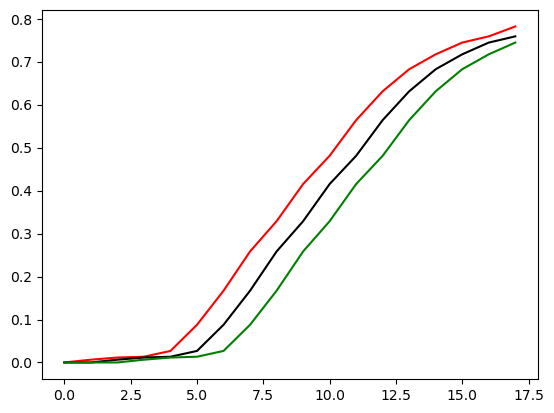

In [51]:
plt.plot(pipeline.knn_training_dataset_augmented.traj[pipeline.knn_training_dataset_augmented.delays==0,0,:][0,:].T,'r')

plt.plot(pipeline.knn_training_dataset_augmented.traj[pipeline.knn_training_dataset_augmented.delays==1,0,:][0,:].T,'k')

plt.plot(pipeline.knn_training_dataset_augmented.traj[pipeline.knn_training_dataset_augmented.delays==2,0,:][0,:].T,'g')

plt.show()

In [52]:
res = pipeline.run(x_sub,y_sub,body_angle_sub)

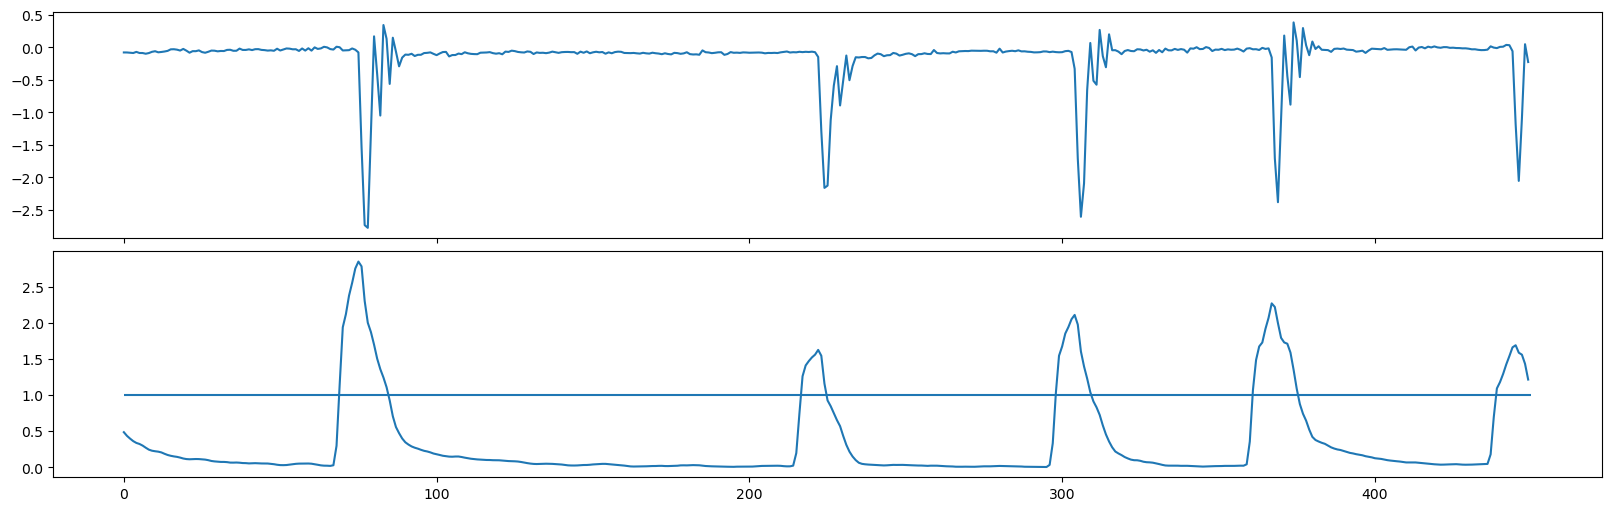

In [28]:
Duration = fps_new*5
IdSt= np.random.randint(res.kinematic_activity.shape[0]-Duration)
fig, (ax) = plt.subplots(2,1,figsize=(16,5), sharex=True,constrained_layout=True)
ax[0].plot(tail_angle_sub[IdSt:IdSt+Duration,6])
ax[1].plot(res.kinematic_activity[IdSt:IdSt+Duration])
ax[1].hlines(1,0,Duration)

plt.show()

In [29]:
onset_super_res = res.segments.onset
onset_super_res = np.array(onset_super_res)

offset_super_res = res.segments.offset
offset_super_res = np.array(offset_super_res)

bout_category = res.classification.bout_category

In [30]:
def compute_indicator(onset,offset,T):
    
    is_interval_acceptable = (onset<T)&(offset<T)
    onset,offset = onset[is_interval_acceptable],offset[is_interval_acceptable]

    x = np.zeros(T)
    for on_,off_ in zip(onset,offset):
        x[on_:off_] = 1
        
    return x
        

In [31]:
res.traj_array.shape

(14253, 3, 18)

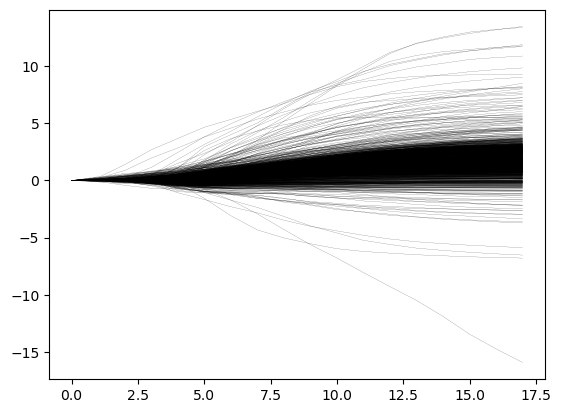

In [32]:
plt.plot(res.traj_array[::10,0,:].T,'k',lw=0.1)
plt.show()

In [33]:
bouts_indicator_full = compute_indicator(onset_full,offset_full,tail_angle.shape[0])
bouts_indicator_sub = compute_indicator(onset_super_res,offset_super_res,tail_angle_sub.shape[0])

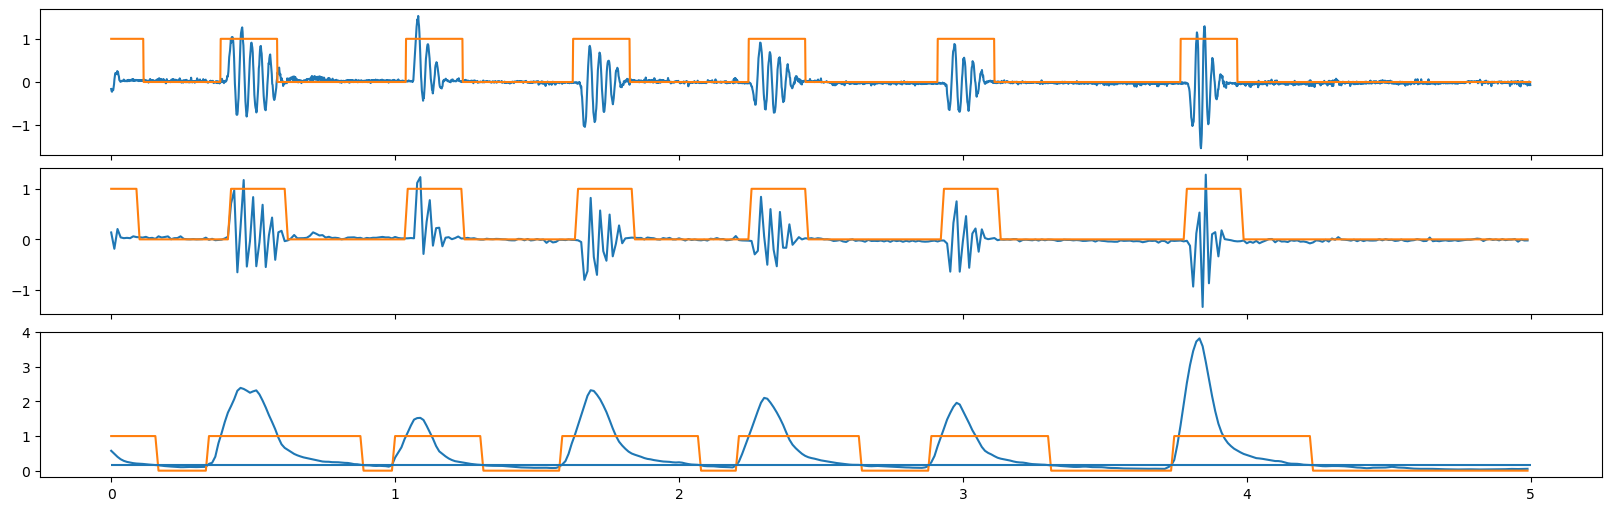

In [34]:
# Display both segmentation on same plot:

Duration = fps_new*5
IdSt_sub= np.random.randint(res.kinematic_activity.shape[0]-Duration)
IdEd_sub = IdSt_sub+Duration

IdSt_full = int(np.round(IdSt_sub*700/fps_new))
IdEd_full = int(np.round(IdEd_sub*700/fps_new))

fig, (ax) = plt.subplots(3,1,figsize=(16,5), sharex=True,constrained_layout=True)

t_ = original_t[IdSt_full:IdEd_full]-original_t[IdSt_full]
t_ = t_/1000
ax[0].plot(t_,tail_angle[IdSt_full:IdEd_full,6])
ax[0].plot(t_,bouts_indicator_full[IdSt_full:IdEd_full])

t_ = new_t[IdSt_sub:IdEd_sub]-new_t[IdSt_sub]
t_ = t_/1000
ax[1].plot(t_,tail_angle_sub[IdSt_sub:IdEd_sub,6])
ax[1].plot(t_,bouts_indicator_sub[IdSt_sub:IdEd_sub])

ax[2].plot(t_,kinematic_activity[IdSt_sub:IdEd_sub])
ax[2].plot(t_,kinematic_activity[IdSt_sub:IdEd_sub]>0.16)
ax[2].hlines(.16,0,Duration/fps_new)

plt.show()


In [35]:
delta_t = 50
label_full = []
label_super = []

N_match = 0
for on_,cat_full in zip(onset_full,bout_cat_full):
    if np.min(np.abs(original_t[on_]-new_t[onset_super_res]))<delta_t:
        id_super = np.argmin(np.abs(original_t[on_]-new_t[onset_super_res]))
        cat_super = bout_category[id_super]
        N_match = N_match+1
        label_full.append(cat_full)
        label_super.append(cat_super)
        
x = np.array(label_full)
y = np.array(label_super)

In [36]:
N_match/len(bout_cat_full)

0.9852694777994974

In [37]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x, y)

0.7104961290135376

In [38]:
balanced_accuracy_score(x%11, y%11)

0.8490203222653854

In [44]:
balanced_accuracy_score(y%11, x%11)

0.852837200636645

In [45]:
balanced_accuracy_score(x%11, y%11)

0.8490203222653854

In [ ]:
-20,20 -> 86.7
-20,25 -> 86.9
-10,25 -> 86.9
-5,25 -> 86.9

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
NameCat = pipeline.knn_training_dataset.bouts_dict['name']

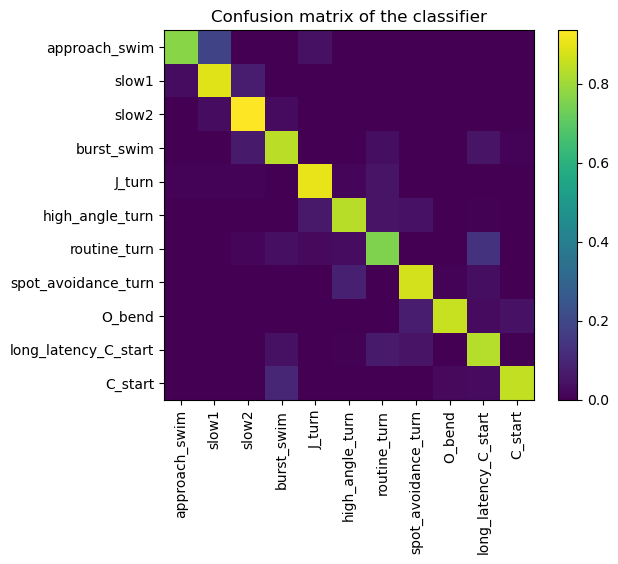

In [43]:

cm = confusion_matrix(x%11, y%11, labels = np.arange(11),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks(np.arange(11),NameCat,rotation=90)
plt.yticks(np.arange(11),NameCat,rotation=0)
plt.show()

In [305]:
#(fps=fps_new,peak_prominence=0.4,margin_before_peak_ms=34,augment_max_delay_ms=40,augment_step_delay_ms=4,N_kNN=5)
# 0.772, 0.843

#(fps=fps_new,peak_prominence=0.4,margin_before_peak_ms=28,augment_max_delay_ms=28,augment_step_delay_ms=4,N_kNN=5)
#0.764,0.841

#(fps=fps_new,peak_prominence=0.4,margin_before_peak_ms=34,augment_max_delay_ms=34,augment_step_delay_ms=4,N_kNN=5)
# 0.775,0.844

#(fps=fps_new,peak_prominence=0.4,margin_before_peak_ms=34,augment_max_delay_ms=34,augment_step_delay_ms=4,N_kNN=5)
# 0.772,0.842

# Check classification results

In [56]:
np.unique(res.classification.bout_category)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int64)

In [195]:
templates_labels = pipeline.knn_training_dataset.labels
print(res.traj_array.shape)
proba = res.classification.proba
outlier = res.classification.outlier_score
kinematic_activity = res.kinematic_activity
bout_cat_ts = res.bout_category_ts

(14384, 3, 140)


In [196]:
NameCat = cfg_classify.bouts_dict['name']

In [197]:
NameCat

['approach_swim',
 'slow1',
 'slow2',
 'burst_swim',
 'J_turn',
 'high_angle_turn',
 'routine_turn',
 'spot_avoidance_turn',
 'O_bend',
 'long_latency_C_start',
 'C_start']

In [54]:
np.unique(res.bout_category_ts),np.unique(res.bout_category_ts_signed)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

In [ ]:
res.classification.bout_category)

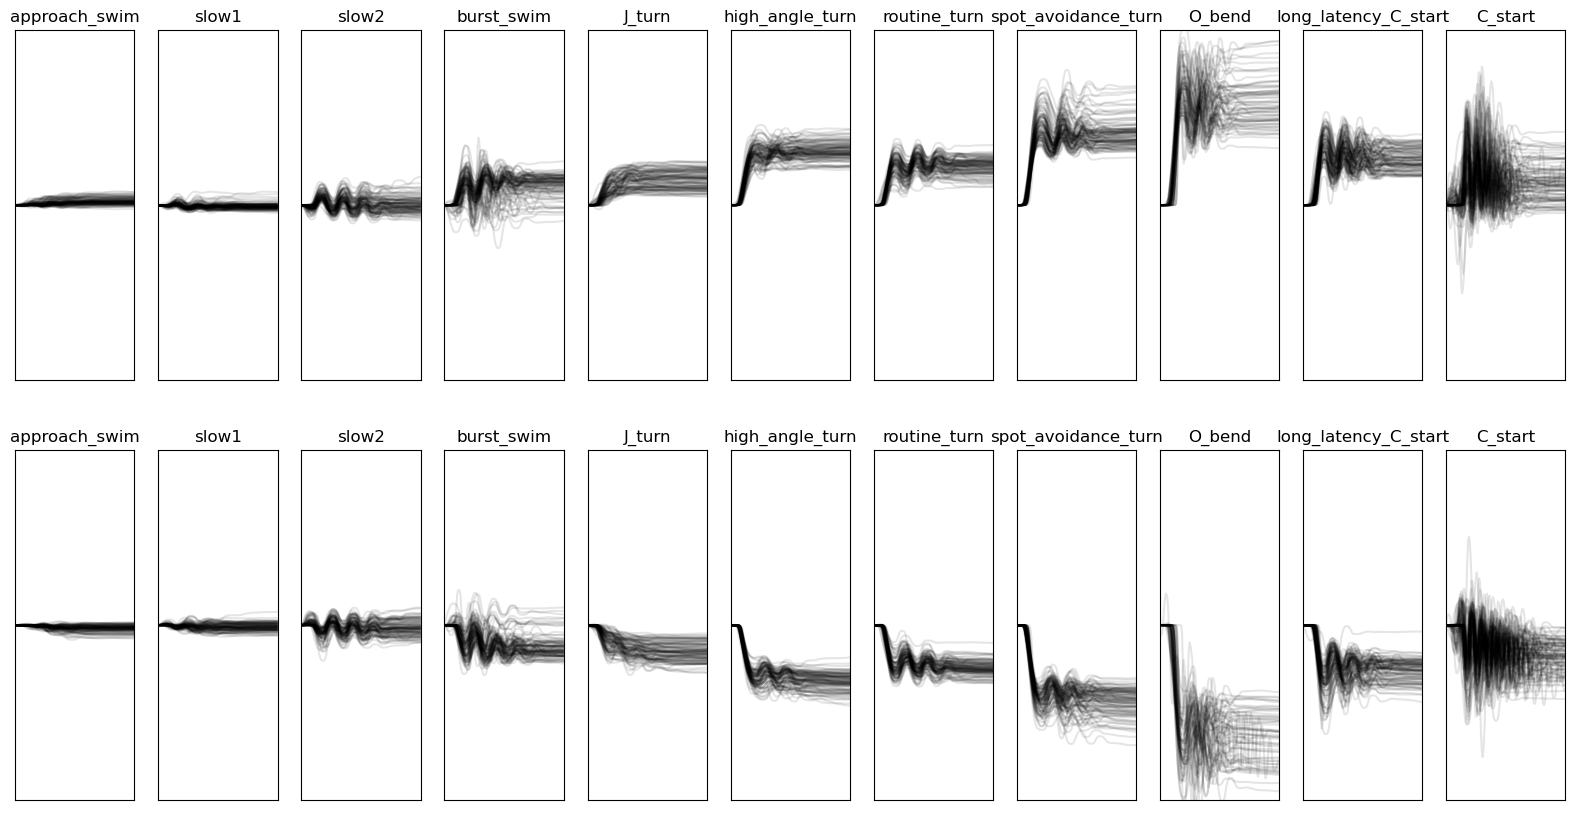

In [198]:
fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,11)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<11 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%11])
    ax0.set_title(NameCat[b%11])
    id = np.where((bout_category==b)&(proba>0.7)&(outlier<2))[0]       
    if len(id)>0:
        id = id[0:100]
        ax0.plot(res.traj_array[id,2,:].T,'k',alpha=0.1)

    ax0.set_xlim(0,cfg_segment.bout_duration)
    ax0.set_ylim(-3.6,3.6)
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()

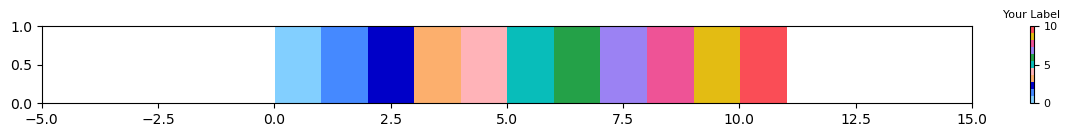

In [199]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

color = cfg_classify.bouts_dict['color']

cmp_bouts = colors.ListedColormap(color)
cmp_bouts.set_under(color='white')
cmp_bouts.set_over(color='white')
cmp_bouts.set_bad(color='grey', alpha=None)

plt.figure(figsize=(15,1))
plt.imshow(np.arange(-5,15)[:,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=10,interpolation='nearest',extent=[-5,15,0,1])
clb=plt.colorbar()
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('Your Label',fontsize=8)
plt.show()

In [210]:

Duration = fps_new*7
IdSt = 7969693#
IdSt = np.random.randint(kinematic_activity.shape[0])
IdEd = IdSt + Duration
t = np.linspace(0,Duration/fps_new,Duration)
sub_onset,sub_offset,sub_i= [],[],[]

for i,(on_,off_) in enumerate(zip(res.segments.onset,res.segments.offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)

sub_i = np.array(sub_i)

sub_traj_array = res.traj_array[sub_i,:,:]
id = res.classification.id_nearest_template[sub_i]
traj_nearest = pipeline.knn_training_dataset.traj[id,:,:]

In [211]:
tail_angle.shape
bout_duration = cfg_segment.bout_duration

In [212]:
bout_cat_ts_full.shape

(8908250,)

(0.0, 7.0)

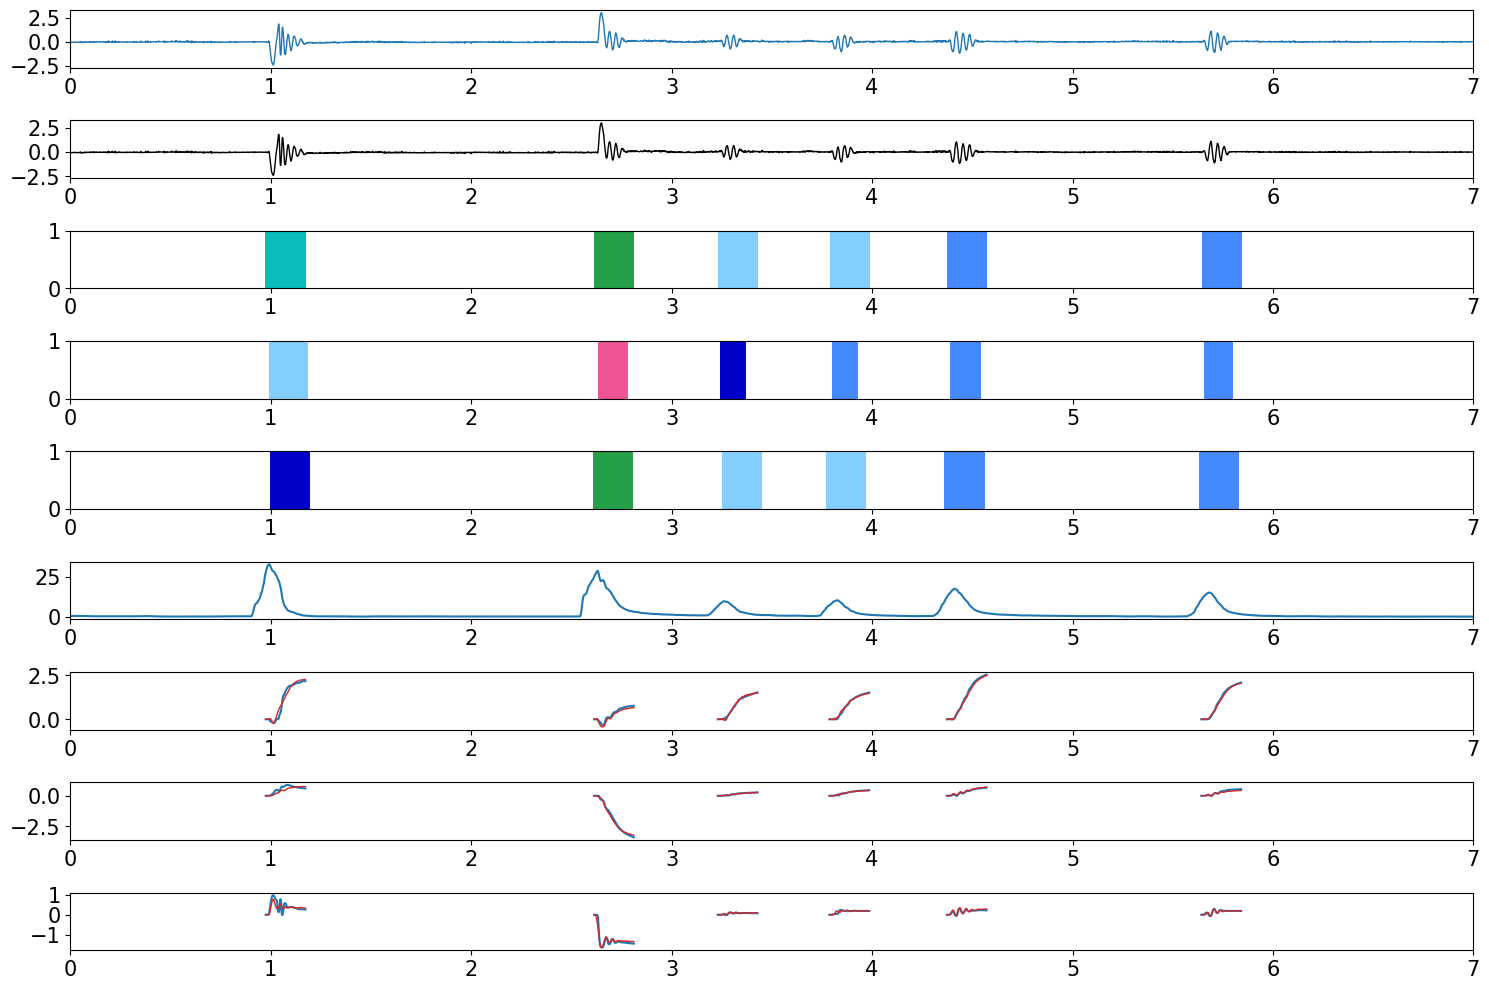

In [213]:

fig, ax = plt.subplots(facecolor='white',figsize=(15,10),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(9,1)

ax = plt.subplot(G[0])
#ax.plot(t,tail_angle[IdSt:IdEd,7],'k',lw=1)
tmp = tail_angle[int(np.round(IdSt*700/fps_new)):int(np.round(IdEd*700/fps_new)),7]
ax.plot(np.linspace(0,7,7*700),tmp,lw=1)
ax.set_xlim(0,7)

ax = plt.subplot(G[1])
ax.plot(t,tail_angle_sub[IdSt:IdEd,7],'k',lw=1)
#ax.plot(t,yaw_speed[IdSt:IdEd],lw=1)
#ax.plot(t,yaw_speed_hat_[IdSt:IdEd],lw=1)
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[2])
ax.imshow(bout_cat_ts[IdSt:IdEd,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,Duration/fps_new,0,1])
ax.set_xlim(0,Duration/fps_new)

#ax = plt.subplot(G[3])
#ax.imshow(bout_cat_ts_matlab[IdSt:IdEd,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,Duration/fps_new,0,1])
#ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[3])
tmp = bout_cat_ts_matlab[int(np.round(IdSt*700/fps_new)):int(np.round(IdEd*700/fps_new)),np.newaxis].T
ax.imshow(tmp,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,7,0,1])
ax.set_xlim(0,7)

ax = plt.subplot(G[4])
tmp = bout_cat_ts_full[int(np.round(IdSt*700/fps_new)):int(np.round(IdEd*700/fps_new)),np.newaxis].T
ax.imshow(tmp,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,7,0,1])
ax.set_xlim(0,7)


ax = plt.subplot(G[5])
ax.plot(t,kinematic_activity[IdSt:IdEd])
#y =-(1-2*(np.max((z[IdSt:IdEd]),axis=1)>np.max(-(z[IdSt:IdEd]),axis=1)))*np.max(np.abs(z[IdSt:IdEd]),axis=1)*peaks_bin[IdSt:IdEd]
#ax.scatter(t[sub_peaks],y[sub_peaks],color = 'r')
#for p in sub_peaks:
#    ax.add_patch(Rectangle((t[p],-10),140/700,20,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/fps_new)


ax = plt.subplot(G[6])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,sub_traj_array[i,0,:],'tab:blue')
    off_ = on_+bout_duration
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,traj_nearest[i,0,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[7])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,sub_traj_array[i,1,:],'tab:blue')
    off_ = on_+bout_duration
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,traj_nearest[i,1,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps_new)


ax = plt.subplot(G[8])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,sub_traj_array[i,2,:],'tab:blue')
    off_ = on_+bout_duration
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,traj_nearest[i,2,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps_new)

### Segmentation accuracy

In [ ]:

delta_t = 50 # only if another onset is located at 50 ms
# onset_full

N_match = 0
for on_ in onset_full:
    if np.min(np.abs(original_t[on_]-new_t[onset_super_res]))<delta_t:
        N_match = N_match+1
    
print(100*N_match/len(onset_full))

### Classification accuracy

In [ ]:

delta_t = 50 # only if another onset is located at 50 ms

label_full = []
label_super = []

N_match = 0
for on_,cat_full in zip(onset_full,bout_cat_full):
    if np.min(np.abs(original_t[on_]-new_t[onset_super_res]))<delta_t:
        id_super = np.argmin(np.abs(original_t[on_]-new_t[onset_super_res]))
        cat_super = bout_category[id_super]
        
        label_full.append(cat_full)
        label_super.append(cat_super)

In [ ]:
#bout_cat_ts_super,bout_cat_ts_signed_super = compute_bout_cat_ts(segment_refined.onset,segment_refined.offset,bout_category,tracking_data.n_frames)


In [30]:
from sklearn.metrics import confusion_matrix


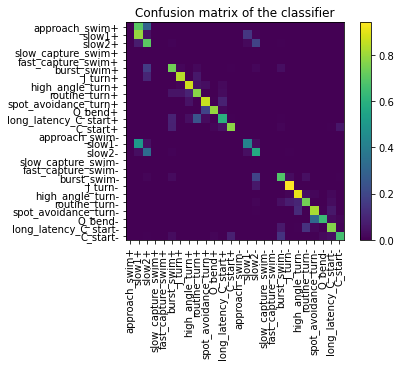

In [38]:
x = np.array(label_full)
y = np.array(label_super)

cm = confusion_matrix(x, y, labels = np.arange(26),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks(np.arange(26),NameCat,rotation=90)
plt.yticks(np.arange(26),NameCat,rotation=0)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(x, y)

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x, y)

In [ ]:
x_sym = x%13
y_sym = y%13

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x_sym,y_sym)

In [ ]:

# Do you find the same label as in the original fps (classification accuracy)

In [ ]:

'''
segments = pipeline['segments']
bout_cat = pipeline['bout_cat']
tail_and_traj_array = pipeline['tail_and_traj_array']
tail_angle = pipeline['tail_angle_detrend']
onset_py = segments.onset
offset_py = segments.offset'''
break

# Save to Plotly

In [ ]:
t = np.arange(0,len(mobility))

fig = make_subplots(rows=3, cols=1,shared_xaxes=True)


for pl in px.imshow(bout_cat_signed.T, x=t, y=np.arange(2)).data:
    fig.add_trace(pl, row=1, col=1)

for pl in px.imshow(df.bout_cat_matlab.values[np.newaxis,:], x=t, y=np.arange(1)).data:
    fig.add_trace(pl, row=2, col=1)


fig.add_trace(go.Scatter(x=t, y=mobility,mode='lines'),
              row=3, col=1)

layout = px.imshow(bout_cat_signed.T,x= t,color_continuous_scale=cmp_bouts_pltly,zmin=-1,zmax=12).layout
fig.layout.coloraxis = layout.coloraxis

fig.update_traces(xaxis="x")

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.write_html("super_resolution_pipeline.html")
